In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

This notebook is a continuation of my previous notebook [TPS Sept: EDA & Baseline Models](https://www.kaggle.com/jaikr18/tps-sept-eda-baseline-models), wherein I focused mainly on EDA and then trained baseline models for *XGBClassifier*, *CatBoostClassifier*, and *LGBMClassifier*. In this notebook, I will focus on optimization of these baseline models. 

# **PROBLEM STATEMENT**

We are given the following:

1. A train dataset (.csv) containing the index column (0 to n_train_examples-1), features ('f1' to 'f118') and the ground truth *claim* (0 or 1) respectively.
2. A test dataset (.csv) containing the index column (0 to n_test_examples-1), features ('f1' to 'f118') respectively.

We are required to implement a binary-classification algorithm which predicts for each example of the test dataset, whether a customer made a claim upon an insurance policy. A '1' value means a claim was made, and '0' means a claim was not made.

# **IMPORT LIBRARIES**

In [ ]:
import numpy as np
import pandas as pd
import datatable as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

# **0. DATASET**

**0.0 LOADING DATASET**

In [ ]:
%%time

train_filename = "../input/tabular-playground-series-sep-2021/train.csv"
test_filename = "../input/tabular-playground-series-sep-2021/test.csv"

train_orig = dt.fread(train_filename).to_pandas()
test_orig = dt.fread(test_filename).to_pandas()

train_orig = train_orig.set_index('id')
test_orig = test_orig.set_index('id')

**0.1 DATASET OVERVIEW**

In [ ]:
train_orig.shape

There are a total of *957919* training examples, having *118* features ranging from 'f1' to 'f118', and *1* target column, i.e. *claim* which corresponds to - whether the claim was made (1) or not (0).

In [ ]:
train_orig.claim = train_orig.claim.astype('int16')
train_orig.info()
print()
test_orig.info()

All the features in the dataset are of type *float64*, and the ground truth column, i.e. *claim* is of type *int16*.

In [ ]:
pd.set_option('display.max_columns', 125)
train_orig.describe()

As expected, the dataset is far from standard with some features taking exponentially large values while some other taking exponentially small values. Also, most features seem to be having missing values, so we will have to take care of these things at a later point.

In [ ]:
train_orig.head(10)

**0.2 MEMORY REDUCTION**

For a large dataset such as this one, one might often face situations where the system runs out of RAM. Thus, it would be wise to cut down on the memory usage.

In [ ]:
train_memory_orig = train_orig.memory_usage().sum() / 1024**2
print('Memory usage of original training set(in MB): {}'.format(train_memory_orig))

def reduce_memory(df):
    for col in df.columns:
        if str(df[col].dtypes)[:5] == 'float':
            low = df[col].min()
            high = df[col].max()
            if((low > np.finfo(np.float16).min) and (high < np.finfo(np.float16).max)):
                df[col] = df[col].astype('float16')
            elif((low > np.finfo(np.float32).min) and (high < np.finfo(np.float).max)):
                df[col] = df[col].astype('float32')
    return df

reduce_memory(train_orig)
train_memory_reduced = train_orig.memory_usage().sum() / 1024**2
print('Memory usage of reduced training set(in MB): {}'.format(train_memory_reduced))

In [ ]:
test_memory_orig = test_orig.memory_usage().sum() / 1024**2
print('Memory usage of original test set(in MB): {}'.format(test_memory_orig))

reduce_memory(test_orig)
test_memory_reduced = test_orig.memory_usage().sum() / 1024**2
print('Memory usage of reduced test set(in MB): {}'.format(test_memory_reduced))

# **1. EXPLORATORY DATA ANALYSIS**

**1.0 DUPLICATE REMOVAL**

First off, there is always a possibility that our dataset is having duplicate entries. This is typically a fault of the data acquisition step.

In [ ]:
#prints the number of duplicated entries(rows)
n_duplicates_train = train_orig.duplicated().sum()
print("Number of duplicated entries in trainng set: {}".format(n_duplicates_train))
n_duplicates_test = test_orig.duplicated().sum()
print('Number of duplicated entries in test set: {}'.format(n_duplicates_test))

This means that our dataset has only unique entries. Having ensured this, now we can proceed to the actual EDA for our dataset.

**1.1 TARGET COLUMN**

In [ ]:
print(train_orig.claim.dtype)
print(train_orig.claim[:10])

In [ ]:
claim_dist = train_orig.claim.value_counts()
display(claim_dist)

Seems pretty well balanced. Let's confirm this notion through a pie chart (because "visual data is always more convincing").

In [ ]:
plt.figure(figsize = (10,6))
claim_dist.plot.pie(autopct = '%.1f', colors = ['powderblue', 'slateblue'])
plt.title("Claim vlaue distribution pie chart", pad = 20, fontdict = {'size' : 15, 'color' : 'darkblue', 'weight' : 'bold'})
plt.show()

>"Perfectly balanced, as all things should be."

**1.2 FEATURE ENGINEERING**

Since we are going to impute NaN later, we would end up losing the information about missing values for the training examples. For that reason, let's add a column which stores the number of NaN entries for each training example.

In [ ]:
train_orig['count_missing'] = train_orig.isna().sum(axis = 1)
test_orig['count_missing'] = test_orig.isna().sum(axis = 1)

print(train_orig['count_missing'].value_counts())
print(test_orig['count_missing'].value_counts())

**1.3 DISTRIBUTION ANALYSIS**

Let's see how the features are distributed w.r.t. the target variable.

**NOTE:** Since we have a very large dataset, we will plot these distributions taking a small sample from the dataset. For better estimations, we will take a random sample, preferably of fraction 1/100 of the original dataset. This will help in faster generation of plots.

In [ ]:
train_frac = train_orig.sample(frac = 0.01).reset_index(drop = True)
#train_frac = train_orig[0:9579]
target = train_frac.claim
#txt = "Kernel Density Estimation Plots w.r.t. the target 'claim' for {} training examples".format(train_frac.shape[0]).center(110)
#print(txt)

c = 4
#r_ = int(np.ceil(len(train_frac.columns)/4))
r = int(np.ceil(train_frac.shape[1]/4))
#print(r, r_)
fig, ax = plt.subplots(nrows = r, ncols = c, figsize = (25,80))
i = 1
for col in train_frac.columns:
    plt.subplot(r, c, i)
    ax = sns.kdeplot(train_frac[col], hue = target, fill = True, multiple = 'stack')
    plt.xlabel(col, fontsize = 15)
    i = i + 1
    
fig.tight_layout(pad = 2.0)
fig.subplots_adjust(top = 0.97)
plt.suptitle("Kernel Density Estimation Plots w.r.t. the target 'claim' for {} training examples".format(train_frac.shape[0]), fontsize = 20)
plt.show()

That's a lot of plots to look at. However, at a quick glance at all the plots, there doesn't seem to be a pattern in any of the distributions w.r.t. the target variable. We will now analyse these weak relations further using a correlation matrix.

**1.4 CORRELATION ANALYSIS**

We noticed earlier that the relation between features and the target variable is most likely weak. To check that further, we'll make use of a correlation matrix. Also, this matrix will help us to check which features are strongly related to one another.

In [ ]:
corrMat = train_frac.corr()

fig, ax = plt.subplots(figsize = (20,20))
cmap = sns.diverging_palette(230, 20, as_cmap = True)
mask = np.triu(np.ones_like(corrMat, dtype = bool))
sns.heatmap(corrMat, square = True, annot = False, linewidths = 1, cmap = cmap, mask = mask)

There are a few darker cells, which represent relatively strong correlation between the concerning features/variables. However, even these *relatively* strong correlations have very small correlation coefficient values from a general P.O.V. To elaborate, the slider on the right depicts that the upper bound on positive correlations is approx 0.04 and the lower bound on negative correlations is approx -0.06. These two bounds are too small to declare a strong correlation between the features.

**Ps:** Here, I define a *strong correlation* as one having correlation coefficient value greater than 0.6 (meaning strong positive correlation) or less than -0.6 (meaning strong negative correlation). Of course, these thresholds are subject to the author.

**Conclusion:** We can now safely say that none of the features have a strong correlation among one another, or with the target variable. This marks the end of a fruitless correlation analysis. 

# **2. DATA CLEANING**

**2.0 DATASET SPLIT**

Before proceeding any further, it is recommended to split the dataset into a training set and a hold-out cross-validation set. This is to ensure that the model we build won't be adversely affected by data leakage.

> Any feature whose value would not actually be available in practice at the time you’d want to use the model to make a prediction, is a feature that can introduce leakage to your model

In [ ]:
from sklearn.model_selection import train_test_split

X = train_orig.copy()
Y = X.claim
X.drop('claim', axis = 1, inplace = True)

X_train_orig, X_valid_orig, Y_train_orig, Y_valid_orig = train_test_split(X, Y, test_size = 0.2,
                                                                         random_state = 42)
X_test_orig = test_orig.copy()

**2.1 MISSING VALUES**

As we saw earlier, most of the features have missing values. We will take care of that now.

Luckily, for the given dataset, we have only numerical features and hence, imputation will be lot more simpler. For numerical data, two most suitable imputation techniques that could be used here are *mean imputation* and *median imputation*. I will try both these techniques and compare their performance on the validation set. In the final notebook, you will only see the technique which performed better. 

In [ ]:
missing_val_cols = X_train_orig.isnull().sum().sort_values(ascending = False)
missing_val_cols = missing_val_cols[missing_val_cols > 0]
ratio_of_missing = missing_val_cols / X_train_orig.shape[0]
missing = pd.concat([missing_val_cols,ratio_of_missing], axis = 1, 
                   keys = ['Count','%'])
missing

Surprisingly, every feature has missing entries. However, the number of missing entries as compared to the entire dataset is quite small.

In [ ]:
from sklearn.impute import SimpleImputer

my_imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean', verbose = False)
my_imputer.fit(X_train_orig)
X_train_imputed = my_imputer.transform(X_train_orig)
X_valid_imputed = my_imputer.transform(X_valid_orig)
X_test_imputed = my_imputer.transform(X_test_orig)

# **3. FEATURE SCALING**



Many machine learning algorithms perform better when numerical input variables are scaled to a standard range.

Standardizing is a popular scaling technique that subtracts the mean from values and divides by the standard deviation, transforming the probability distribution for an input variable to a standard Gaussian (zero mean and unit variance). Standardization can become skewed or biased if the input variable contains outlier values.

To overcome this, the median and interquartile range can be used when standardizing numerical input variables, generally referred to as robust scaling.

In [ ]:
from sklearn.preprocessing import RobustScaler, StandardScaler

robust_scaler = RobustScaler()
robust_scaler.fit(X_train_imputed)
X_train_robust = robust_scaler.transform(X_train_imputed)
X_valid_robust = robust_scaler.transform(X_valid_imputed)
X_test_robust = robust_scaler.transform(X_test_imputed)

standard_scaler = StandardScaler()
standard_scaler.fit(X_train_imputed)
X_train_scaled = standard_scaler.transform(X_train_imputed)
X_valid_scaled = standard_scaler.transform(X_valid_imputed)
X_test_scaled = standard_scaler.transform(X_test_imputed)

On passing through the Scalers, our Data Frame has now been converted to a numpy array. So, for convention, we will convert the array back to a Data Frame.

In [ ]:
X_train_final = pd.DataFrame(X_train_scaled, index = X_train_orig.index,
                            columns = X_train_orig.columns)
X_valid_final = pd.DataFrame(X_valid_scaled, index = X_valid_orig.index, 
                            columns = X_valid_orig.columns)
X_test_final = pd.DataFrame(X_test_scaled, index = X_test_orig.index, 
                           columns = X_test_orig.columns)

In [ ]:
#final training set
X_train_final.describe()

# **4. MODEL FITTING AND EVALUATION**

In the last notebook, linked -> [TPS Sept: EDA & Baseline Models](https://www.kaggle.com/jaikr18/tps-sept-eda-baseline-models), we trained three baseline models, namely *XGBClassifier*, *CatBoostClassifier*, and *LGBMClassifier*. Their performance evaluations are as shown below:

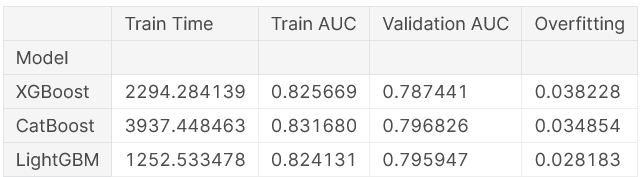

From here on, the main emphasis will be on optimizing these baseline models in order to get better performance.

**4.1 OPTIMIZATION**

When we talk about optimizing our models, we mean optimizing the hyperparameters of our model and getting the best set of hyperparameters that would maximize the performance of that particular model. To carry out this task, we have a number of techniques, namely:

- Grid Search with cross-validation. Here, we have to feed a grid of different hyperparamer values and a model will be trained for every possible combination of hyperparameter values. In the end, the combination that gave the best result is selected.
- Randomized Search with cross-validation. Here, we do not specify a set of hyperparameter values. Instead, we sample values from a statistical distribution for each hyperparameter. It might not select the absolute best combination of hyperparameters but it's always pretty close to the best, **and** it runs a lot faster than Grid Search. 
- Bayesian Optimization methods. Here, in contrast to random or grid search, we keep track of past evaluation results which are used to form a probabilistic model mapping hyperparameters to a probability of a score on the objective function. Too much info right? Refer to [this](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f) blog for more details.

Since we have a large dataset for which model fitting would be very costly, we will go with Bayesian Optimization.

In [ ]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

#library to implement Bayesian Optimization
import optuna

**4.1.1 XGB CLASSIFIER**

In [ ]:
#see documentation to analyse hyperparameters
#help(XGBClassifier())

- **Optimizing Objective Function Using Optuna**

In [ ]:
from sklearn.metrics import roc_auc_score
from optuna.integration import XGBoostPruningCallback
from sklearn.model_selection import StratifiedKFold

def get_score(actual, preds):
    score = roc_auc_score(actual,preds)
    return score

# def objective_function(trial):
#     n_estimators = trial.suggest_int('n_estimators', 5000, 30000)
#     use_label_encoder = trial.suggest_categorical('use_label_encoder',['False'])
#     max_depth = trial.suggest_int('max_depth', 2, 10)
#     learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)
#     colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.9)
#     objective = trial.suggest_categorical('objective',['binary:logistic'])
#     eval_metric = trial.suggest_categorical('eval_metric',['auc','logloss'])
#     booster = trial.suggest_categorical('booster',['gbtree'])
#     tree_method = trial.suggest_categorical('tree_method',['gpu_hist'])
#     predictor = trial.suggest_categorical('predictor',['gpu_predictor'])
#     subsample = trial.suggest_float('subsample', 0.3, 0.9)
#     gamma = trial.suggest_float('gamma', 0.005, 0.5, log = True)
#     reg_alpha = trial.suggest_float('reg_alpha', 0.1, 20, log = True)
#     reg_lambda = trial.suggest_float('reg_lambda', 0.1, 20, log = True)
#     min_child_weight = trial.suggest_int('min_child_weight', 1, 250)
    
#     params = {'n_estimators' : n_estimators, 
#               'use_label_encoder' : use_label_encoder,
#               'max_depth' : max_depth, 
#               'learning_rate' : learning_rate,
#               'colsample_bytree' : colsample_bytree, 
#               'objective' : objective, 
#               'eval_metric' : eval_metric,
#               'booster' : booster, 
#               'subsample' : subsample, 
#               'tree_method' : tree_method,
#               'predictor' : predictor,
#               'gamma' : gamma, 
#               'reg_alpha' : reg_alpha, 
#               'reg_lambda' : reg_lambda,
#               'min_child_weight' : min_child_weight, 
#               'random_state' : 42}
    
#     KFold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
#     fold_scores = np.zeros(5)
    
#     for idx, (train_idx, valid_idx) in enumerate(KFold.split(X_train_final,Y_train_orig)):
#         print('------------------------------Fold {}------------------------------'.format(idx))
#         Xt, Xv = X_train_final.iloc[train_idx], X_train_final.iloc[valid_idx]
#         Yt, Yv = Y_train_orig.iloc[train_idx], Y_train_orig.iloc[valid_idx]
    
#         xgb = XGBClassifier(**params)
    
#         xgb.fit(Xt, Yt, early_stopping_rounds = 50,
#                eval_set = [(Xv,Yv)], verbose = False)
#                #callbacks = [XGBoostPruningCallback(trial,'validation-error')])
    
#         preds = xgb.predict_proba(Xv)[:,1]
        
#         fold_scores[idx] = get_score(Yv,preds)
    
#     return np.mean(fold_scores)

# study = optuna.create_study(direction = 'maximize')
# study.optimize(objective_function, show_progress_bar = True, n_trials = 100)

- **Printing Best Parameters**

In [ ]:
# trial = study.best_trial
# print('Best Value: {}'.format(trial.value))
# print('Best Parameters: ')
# for param, value in trial.params.items():
#     print('{} : {}'.format(param,value))

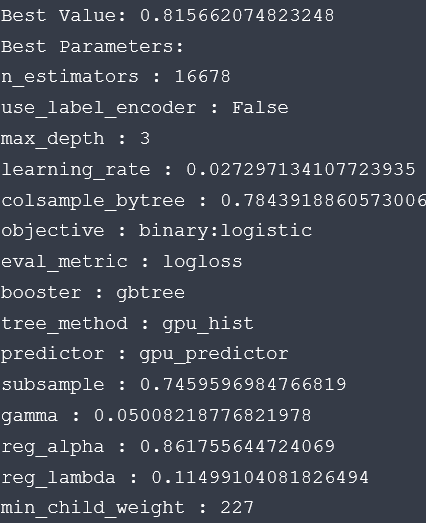

- **Training Final XGB Model**

In [ ]:
import time

xgb_params = {'n_estimators' : 16678,
             'use_label_encoder' : 'False',
             'max_depth' : 3,
             'learning_rate' : 0.027297134107723935,
             'colsample_bytree' : 0.7843918860573006,
             'objective' : 'binary:logistic', 
             'subsample' : 0.7459596984766819,
             'gamma' : 0.05008218776821978,
             'reg_alpha' : 0.861755644724069,
             'reg_lambda' : 0.11499104081826494,
             'min_child_weight' : 227, 
             'eval_metric' : 'logloss',
             'booster' : 'gbtree',
             'tree_method' : 'gpu_hist',
             'predictor' : 'gpu_predictor',
             'random_state' : 42}

xgb = XGBClassifier(**xgb_params)

#fit model
xgb_fit_start = time.time()
xgb.fit(X_train_final,Y_train_orig, early_stopping_rounds = 100,
       eval_set = [(X_valid_final,Y_valid_orig)], verbose = False)
xgb_fit_end = time.time()

#make predictions
xgb_valid_preds = xgb.predict_proba(X_valid_final)[:,1]
xgb_train_preds = xgb.predict_proba(X_train_final)[:,1]

#get scores
xgb_valid_score = get_score(Y_valid_orig,xgb_valid_preds)
xgb_train_score = get_score(Y_train_orig,xgb_train_preds)

print('Validation AUC score for XGBoost: {}'.format(xgb_valid_score))
print('Training AUC score for XGBoost: {}'.format(xgb_train_score))
print('Training time: {}'.format(xgb_fit_end - xgb_fit_start))

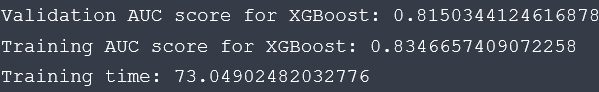

- **Saving CV Score For Comparison**

In [ ]:
#storing score and time for comparison
xgb_valid_score = 0.8150344124616878
xgb_train_score = 0.8346657409072258
xgb_time = 73.04902482032776

**4.1.2 CatBoost Classifier**

In [ ]:
#see documentation to analyse hyperparameters
#help(CatBoostClassifier())

- **Optimizing Objective Function Wtih Optuna**

In [ ]:
#Y_train_cat = Y_train_orig.astype(float)

# def objective_function(trial):
#     n_estimators = trial.suggest_int('n_estimators', 1000, 20000, step = 100)
#     learning_rate = trial.suggest_float('learning_rate', 0.001, 2, log = True)
#     max_depth = trial.suggest_int('max_depth', 4, 10)
#     reg_lambda = trial.suggest_float('reg_lambda', 0.1, 50, step = 0.1)
#     random_strength = trial.suggest_float('random_strength', 0.1, 50, log = True)
#     loss_function = trial.suggest_categorical('loss_function', ['Logloss','CrossEntropy'])
#     bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian','Bernoulli'])
#     subsample = None
#     bagging_temperature = None
#     if(bootstrap_type == 'Bernoulli'):
#         subsample = trial.suggest_float('subsample', 0.3, 1)
#     elif(bootstrap_type == 'Bayesian'):
#         bagging_temperature = trial.suggest_float('bagging_temperature', 0, 1)
#     colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.3, 1)
    
#     params = {'n_estimators' : n_estimators,
#              'learning_rate' : learning_rate,
#              'max_depth' : max_depth,
#              'reg_lambda' : reg_lambda,
#              'random_strength' : random_strength,
#              'loss_function' : loss_function,
#              'bootstrap_type' : bootstrap_type,
#              'subsample' : subsample,
#              'bagging_temperature' : bagging_temperature,
#              'colsample_bylevel' : colsample_bylevel,
#               'thread_count' : 4,
#              'random_state' : 42}
    
#     KFold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
#     fold_scores = np.zeros(5)
    
#     for idx, (train_idx, valid_idx) in enumerate(KFold.split(X_train_final,Y_train_orig)):
#         print('------------------------------Fold {}------------------------------'.format(idx))
#         Xt, Xv = X_train_final.iloc[train_idx], X_train_final.iloc[valid_idx]
#         Yt, Yv = Y_train_orig.iloc[train_idx], Y_train_orig.iloc[valid_idx]
        
#         cat = CatBoostClassifier(**params)
        
#         cat.fit(Xt, Yt, early_stopping_rounds = 50,
#                eval_set = [(Xv,Yv)], verbose = False)
        
#         preds = cat.predict_proba(Xv)[:,1]
        
#         fold_scores[idx] = get_score(Yv,preds)
        
#     return np.mean(fold_scores)
    

# study = optuna.create_study(direction = 'maximize')
# study.optimize(objective_function, show_progress_bar = True, n_trials = 20)

- **Printing Best Parameters**

In [ ]:
# trial = study.best_trial
# print('Best Value: {}'.format(trial.value))
# print('Best Parameters:')
# for param, value in trial.params.items():
#     print('{} : {}'.format(param,value))

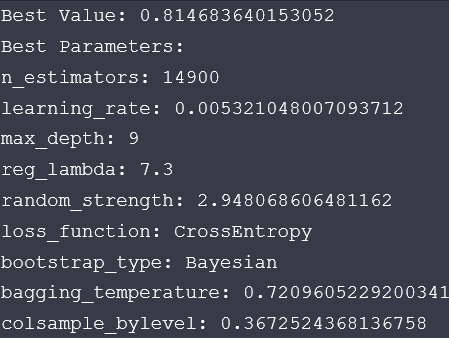

- **Training Final CatBoost Model**

In [ ]:
# cat_params = {'n_estimators' : 14900,
#              'learning_rate' : 0.005321048007093712,
#              'max_depth' : 9,
#              'reg_lambda' : 7.3,
#              'random_strength' : 2.948068606481162,
#              'loss_function' : 'CrossEntropy',
#              'bootstrap_type' : 'Bayesian',
#              'bagging_temperature' : 0.7209605229200341,
#              'colsample_bylevel' : 0.3672524368136758,
#              'random_state' : 42}

# cat  = CatBoostClassifier(**cat_params)

# #fit model
# cat_fit_start = time.time()
# cat.fit(X_train_final,Y_train_orig,early_stopping_rounds = 50,
#        eval_set = [(X_valid_final,Y_valid_orig)], verbose = False)
# cat_fit_end = time.time()

# #make predictions
# cat_valid_preds = cat.predict_proba(X_valid_final)[:,1]
# cat_train_preds = cat.predict_proba(X_train_final)[:,1]

# #get score
# cat_valid_score = get_score(Y_valid_orig,cat_valid_preds)
# cat_train_score = get_score(Y_train_orig,cat_train_preds)

# print('Validation AUC score for CatBoost: {}'.format(cat_valid_score))
# print('Training AUC score for CatBoost: {}'.format(cat_train_score))
# print('Training Time: {}'.format(cat_fit_end - cat_fit_start))

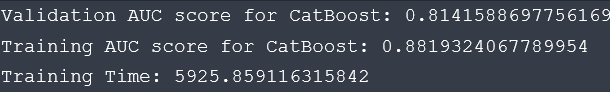

- **Saving Scores For Comparison**

In [ ]:
cat_valid_score = 0.8141588697756169
cat_train_score = 0.8819324067789954
cat_time = 5925.859116315842

**4.1.3 LIGHTGBM CLASSIFIER**

In [ ]:
#see documentation to analyse hyperparameters
#help(LGBMClassifier())

- **Optimizing Objective Function With Optuna**

In [ ]:
# from optuna.integration import LightGBMPruningCallback

# def objective_function(trial):
#     n_estimators = trial.suggest_int('n_estimators', 5000, 20000)
#     max_depth = trial.suggest_int('max_depth', 3, 10)
#     learning_rate = trial.suggest_float('learning_Rate', 0.001, 10, log = True)
#     num_leaves = trial.suggest_int('num_leaves', 1, 500, step = 10)
#     objective = trial.suggest_categorical('objective', ['binary'])
#     metric = trial.suggest_categorical('metric', ['auc'])
#     min_child_weight = trial.suggest_float('min_child_weight', 0.0001, 200, log = True)
#     subsample = trial.suggest_float('subsample', 0.3, 0.9)
#     subsample_freq = trial.suggest_categorical('subsample_freq', [1])
#     colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.9)
#     reg_alpha = trial.suggest_float('reg_alpha', 1, 50, step = 0.1)
#     reg_lambda = trial.suggest_float('reg_lambda', 1, 50, step = 0.1)
#     min_gain_to_split = trial.suggest_float('min_gain_to_split', 0.1, 30, step = 0.1)
#     #device = 'gpu'
#     #gpu_platform_id = 0
#     #gpu_device_id = 0
    
#     params = {'n_estimators' : n_estimators, 
#               'max_depth' : max_depth, 
#               'learning_rate' : learning_rate, 
#               'num_leaves' : num_leaves,
#               'objective' : objective, 
#               'metric' : metric, 
#               'min_child_weight' : min_child_weight, 
#               'subsample' : subsample, 
#               'subsample_freq' : subsample_freq, 
#               'colsample_bytree' : colsample_bytree, 
#               'reg_alpha' : reg_alpha, 
#               'reg_lambda' : reg_lambda, 
#               'min_gain_to_split' : min_gain_to_split, 
#               #'device' : device,
#               #'gpu_platform_id' : gpu_platform_id,
#               #'gpu_device_id' : gpu_device_id,
#               'random_state' : 42}

#     KFold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
#     fold_scores = np.zeros(5)
    
#     for idx, (train_idx, valid_idx) in enumerate(KFold.split(X_train_final,Y_train_orig)):
#         print('------------------------------Fold {}------------------------------'.format(idx))
#         Xt, Xv = X_train_final.iloc[train_idx], X_train_final.iloc[valid_idx]
#         Yt, Yv = Y_train_orig.iloc[train_idx], Y_train_orig.iloc[valid_idx]
        
#         lgbm = LGBMClassifier(**params)
        
#         lgbm.fit(Xt,Yt,early_stopping_rounds = 50,
#                  eval_metric = 'auc', eval_set = [(Xv,Yv)], verbose = False,
#                  callbacks = [LightGBMPruningCallback(trial, 'auc')],verbose = False)
        
#         preds = lgbm.predict_proba(Xv)[:,1]
        
#         fold_scores[idx] = get_score(Yv,preds)
        
#         #results = lgbm.evals_result_
#         #epochs = len(results['validation_0']['auc'])
#         #fig, ax = plt.subplots()
#         #ax.plot(range(0,epochs), results['validation_0']['auc'])
#         #plt.xlabel('epochs') 
#         #plt.ylabel('auc')
    
#     return np.mean(fold_scores)

# study = optuna.create_study(direction = 'maximize')
# study.optimize(objective_function, show_progress_bar = True, n_trials = 40)

- **Printing Best Parameters**

In [ ]:
# trial = study.best_trial
# print('Best Value: {}'.format(trial.value))
# print('Best Parameters:')
# for param, value in trial.params.items():
#     print('{} : {}'.format(param,value))

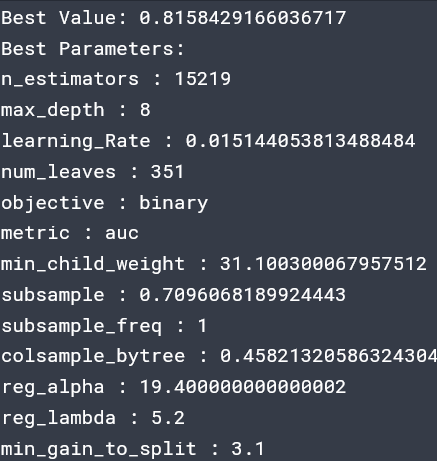

- **Training Final LGBM Model**

In [ ]:
# lgbm_params = {'n_estimators' : 15219, 
#                'max_depth' : 8,
#                'learning_rate' : 0.015144053813488484,
#                'num_leaves' : 351,
#                'objective' : 'binary',
#                'metric' : 'auc',
#                'min_child_weight' : 31.100300067957512,
#                'subsample' : 0.7096068189924443,
#                'subsample_freq' : 1,
#                'colsample_bytree' : 0.45821320586324304,
#                'reg_alpha' : 19.400000000000002,
#                'reg_lambda' : 5.2,
#                'min_gain_to_split' : 3.1,
#                'random_state' : 42}

# lgbm = LGBMClassifier(**lgbm_params)

# #fit model
# lgbm_fit_start = time.time()
# lgbm.fit(X_train_final,Y_train_orig,early_stopping_rounds = 50,
#         eval_metric = 'auc', verbose = False, eval_set = [(X_valid_final,Y_valid_orig)])
# lgbm_fit_end = time.time()

# #make predictions
# lgbm_valid_preds = lgbm.predict_proba(X_valid_final)[:,1]
# lgbm_train_preds = lgbm.predict_proba(X_train_final)[:,1]

# #get score
# lgbm_valid_score = get_score(Y_valid_orig,lgbm_valid_preds)
# lgbm_train_score = get_score(Y_train_orig,lgbm_train_preds)

# print('Validation AUC score for LGBM: {}'.format(lgbm_valid_score))
# print('Training AUC score for LGBM: {}'.format(lgbm_train_score))
# print('Training Time: {}'.format(lgbm_fit_end - lgbm_fit_start))

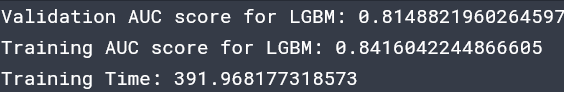

- **Saving Scores For Comparison**

In [ ]:
lgbm_valid_score = 0.8148821960264597
lgbm_train_score = 0.8416042244866605
lgbm_time = 587.968177318573

**4.3 COMPARE PERFORMANCES**

In [ ]:
#overfitting metric, training auc - validatio auc
xgb_of = xgb_train_score - xgb_valid_score
cat_of = cat_train_score - cat_valid_score
lgbm_of = lgbm_train_score - lgbm_valid_score

xgb_eval = {'Model' : 'XGBoost',
           'Train Time' : xgb_time,
           'Train AUC' : xgb_train_score,
           'Validation AUC' : xgb_valid_score,
           'Overfitting' : xgb_of}

cat_eval = {'Model' : 'CatBoost',
           'Train Time' : cat_time,
           'Train AUC' : cat_train_score,
           'Validation AUC' : cat_valid_score,
           'Overfitting' : cat_of}

lgbm_eval = {'Model' : 'LightGBM',
            'Train Time' : lgbm_time,
            'Train AUC' : lgbm_train_score,
            'Validation AUC' : lgbm_valid_score,
            'Overfitting' : lgbm_of}

evaluations = pd.DataFrame({'Model' : [],
                           'Train Time' : [],
                           'Train AUC' : [],
                           'Validation AUC' : [],
                           'Overfitting' : []})
evaluations = evaluations.append([xgb_eval,cat_eval,lgbm_eval], ignore_index = True)
evaluations.set_index('Model', inplace = True)

evaluations

**CONCLUSION**

- There is slight overfitting in *CatBoost* as compared to the other two.
- If training time is considered, then *XGBoost* has clearly outperformed the other two due to the additional GPU support, whereas *CatBoost* took more than 10x the time taken by *LightGBM*.
- If validation AUC is considered, then we can say that both *XGBoost* and *LightGBM* performed equally well on the validation set, with *XGBoost* being just a tad bit better (difference in the AUC scores is approximately **0.0001**).

So, all things considered, we have two almost equally well performing models. Out of these, *XGBoost* was just a speck ahead due to better training time and slightly higher validation score.

On a different note, the training AUC score for *XGBoost* is closer to its validation AUC as compared to the training AUC of *LightGBM* and its validation AUC.

# **5. SUBMISSION**

Let's predict the claim variable for test set and submit our results!

In [ ]:
X_test_final.shape

In [ ]:
#prediction
xgb_test_preds = xgb.predict_proba(X_test_final)[:,1]

#reshape distorted prediction array
xgb_test_preds = xgb_test_preds.reshape(len(X_test_final),)

In [ ]:
output = pd.DataFrame({'id' : X_test_final.index, 'claim' : xgb_test_preds})

output.to_csv('submission.csv', index = False)

# **REFERENCES**

- Hyperparameter optimization using Bayesian methods --> [blog](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f)
- How to make your model awesome with Optuna --> [blog](https://towardsdatascience.com/how-to-make-your-model-awesome-with-optuna-b56d490368af)
- LightGBM Classifier in Python --> [notebook](https://www.kaggle.com/prashant111/lightgbm-classifier-in-python)
- Handling large datasets --> [notebook](https://www.kaggle.com/bextuychiev/how-to-work-w-million-row-datasets-like-a-pro)
- Accelerating XGBoost with GPU --> [notebook](https://www.kaggle.com/vinhnguyen/accelerating-xgboost-with-gpu)

# THANK YOU FOR READING!